# Results from WandB


## Imports

In [1]:
import wandb
from community.utils.wandb_utils import get_wandb_artifact, get_wandb_runs
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import json
import seaborn as sns
import pandas as pd
import numpy.linalg as LA


## Load Results

In [2]:
sweep_path = "gbena/funcspec/mjw4dzu9"
sweep_path = "m2snn/funcspec_V2/lf31u7wy"
sweep_path = "m2snn/funcspec_V2/etsyghun"
sweep_path = "m2snn/funcspec_V2/y1n0vtbp"
sweep_path = "m2snn/funcspec_V2/if1h3qpo"
sweep_path = "m2snn/funcspec_V2/o90n8wvw"
sweep_path = "m2snn/funcspec_V2/t3avf3g4"
sweep_path = "m2snn/funcspec_V2/0cwq0u1o"

sweep_id = sweep_path.split("/")[-1]

total_data = pd.read_pickle(f"../../results/sweep_tables/{sweep_id}")
total_data.columns, total_data.shape

(Index(['Step', 'best_acc', 'common_input', 'common_readout', 'n_hidden',
        'sparsity', 'bottleneck_det', 'bottleneck_det_col_norm',
        'bottleneck_norm_1', 'bottleneck_norm_2', 'bottleneck_norm_fro',
        'bottleneck_norm_nuc', 'bottleneck_global_diff', 'name'],
       dtype='object'),
 (35450, 14))

In [4]:
def filter_data(data, key, value):
    if value is None:
        return data[data[key].isnull()]
    else:
        return data[data[key] == value]

step_datas = [filter_data(total_data, "Step", s) for s in [1, 2]]

tasks = ["all"]
varying_params = [{"common_readout": [True, False]}, {"common_input": [True, False]}]

try : 
    f_data = [filter_data(step_datas[-1], "task", t) for t in tasks]
except KeyError : 
    f_data = step_datas

[t.shape for t in f_data]

[(17725, 14), (17725, 14)]

In [5]:
def get_values(data) : 
    return data[["n_hidden", "sparsity", "bottleneck_global_diff"]].values.T

## Plot Smooth Heatmap

In [6]:
def gaussian_filter(x, y, sigmas):

    eps = 1e-10
    filter = np.exp(-((x / sigmas[0]) ** 2 + (y / sigmas[1]) ** 2))

    return filter


def filter_nans(values):
    idxs = np.isnan(values[-1])
    return [v[~idxs] for v in values]


def weighted_average(x, y, sigmas, values):

    x_values, y_values, z_values = values

    return (
        (z_values * gaussian_filter(x - x_values, y - y_values, sigmas))
    ).sum() / gaussian_filter(x - x_values, y - y_values, sigmas).sum()


def plot_filters(sigmas, values):
    x_values, y_values, z_values = values

    Y = np.linspace(y_values.min(), y_values.max(), 100)
    X = np.linspace(x_values.min(), x_values.max(), 100)

    points = [10, 50, 90]

    fig, axs = plt.subplots(1, len(points), figsize=(10, 5))
    for p, ax in zip(points, axs):

        point = [X[p], Y[p]]
        filter = lambda x, y: gaussian_filter(
            (x - point[0]), y - point[1], sigmas=sigmas
        ).sum()

        Z = np.array([[filter(x, y) for x in X] for y in Y])
        sns.heatmap(Z, ax=ax)


def movingaverage(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, "same")


def compute_and_plot(
    values, figax=None, log_scale=False, plot_f=False, random=True, minmax=(None, None)
):

    x_values, y_values, z_values = filter_nans(values)

    if random:
        idxs = np.arange(len(x_values))
        np.random.shuffle(idxs)
        idxs = idxs[: len(idxs) // 10]
        values = x_values, y_values, z_values = (
            x_values[idxs],
            y_values[idxs],
            z_values[idxs],
        )

    smoothness = 7
    resolution = 300
    eps = 1e-4

    if not log_scale:
        X = np.linspace(x_values.min(), x_values.max(), resolution)
        Y = np.linspace(
            y_values.min(), y_values.max(), resolution
        )  # 500 x 500 takes 10s
    else:
        X = np.geomspace(np.maximum(x_values.min(), eps), x_values.max(), resolution)
        Y = np.geomspace(np.maximum(y_values.min(), eps), y_values.max(), resolution)
        # print(Y)
        # print(Y)

    Xm, Ym = np.meshgrid(X, Y)

    ratio = y_values / x_values
    ratio = movingaverage(ratio, len(ratio) // 3)
    sigmas = np.array([np.ones_like(ratio), ratio * 3]) * smoothness

    ratio = (y_values / x_values).mean()
    sigmas = np.array([1, 2 * ratio]) * smoothness

    vect_avg = np.vectorize(
        lambda x, y: weighted_average(x, y, sigmas, values), signature=("(),()->()")
    )
    Z = vect_avg(Xm, Ym)

    if plot_f:
        plot_filters(sigmas, values)

    if (figax) is None:

        plt.figure(figsize=(20, 10))
        plt.pcolormesh(X, Y, Z, cmap="viridis", vmin=minmax[0], vmax=minmax[1])
        if log_scale:

            """"""
            # plt.xscale("log")
            plt.yscale("log")

        plt.ylim(y_values.min(), y_values.max())
        plt.xlim(x_values.min(), x_values.max())

        # plt.grid(True)
        plt.colorbar()
    else:
        fig, ax = figax
        pc = ax.pcolormesh(X, Y, Z, cmap="viridis", vmin=minmax[0], vmax=minmax[1])
        if log_scale:

            """"""
            #ax.set.xscale("log")
            #ax.set_yscale("log")

        ax.set_ylim(y_values.min(), y_values.max())
        ax.set_xlim(x_values.min(), x_values.max())

        fig.colorbar(pc, ax=ax)

    return (X, Y), (Xm, Ym), Z, sigmas

### heatmap

(4815, 14)
(3875, 14)
(4725, 14)
(4310, 14)
(4815, 14)
(3875, 14)
(4725, 14)
(4310, 14)


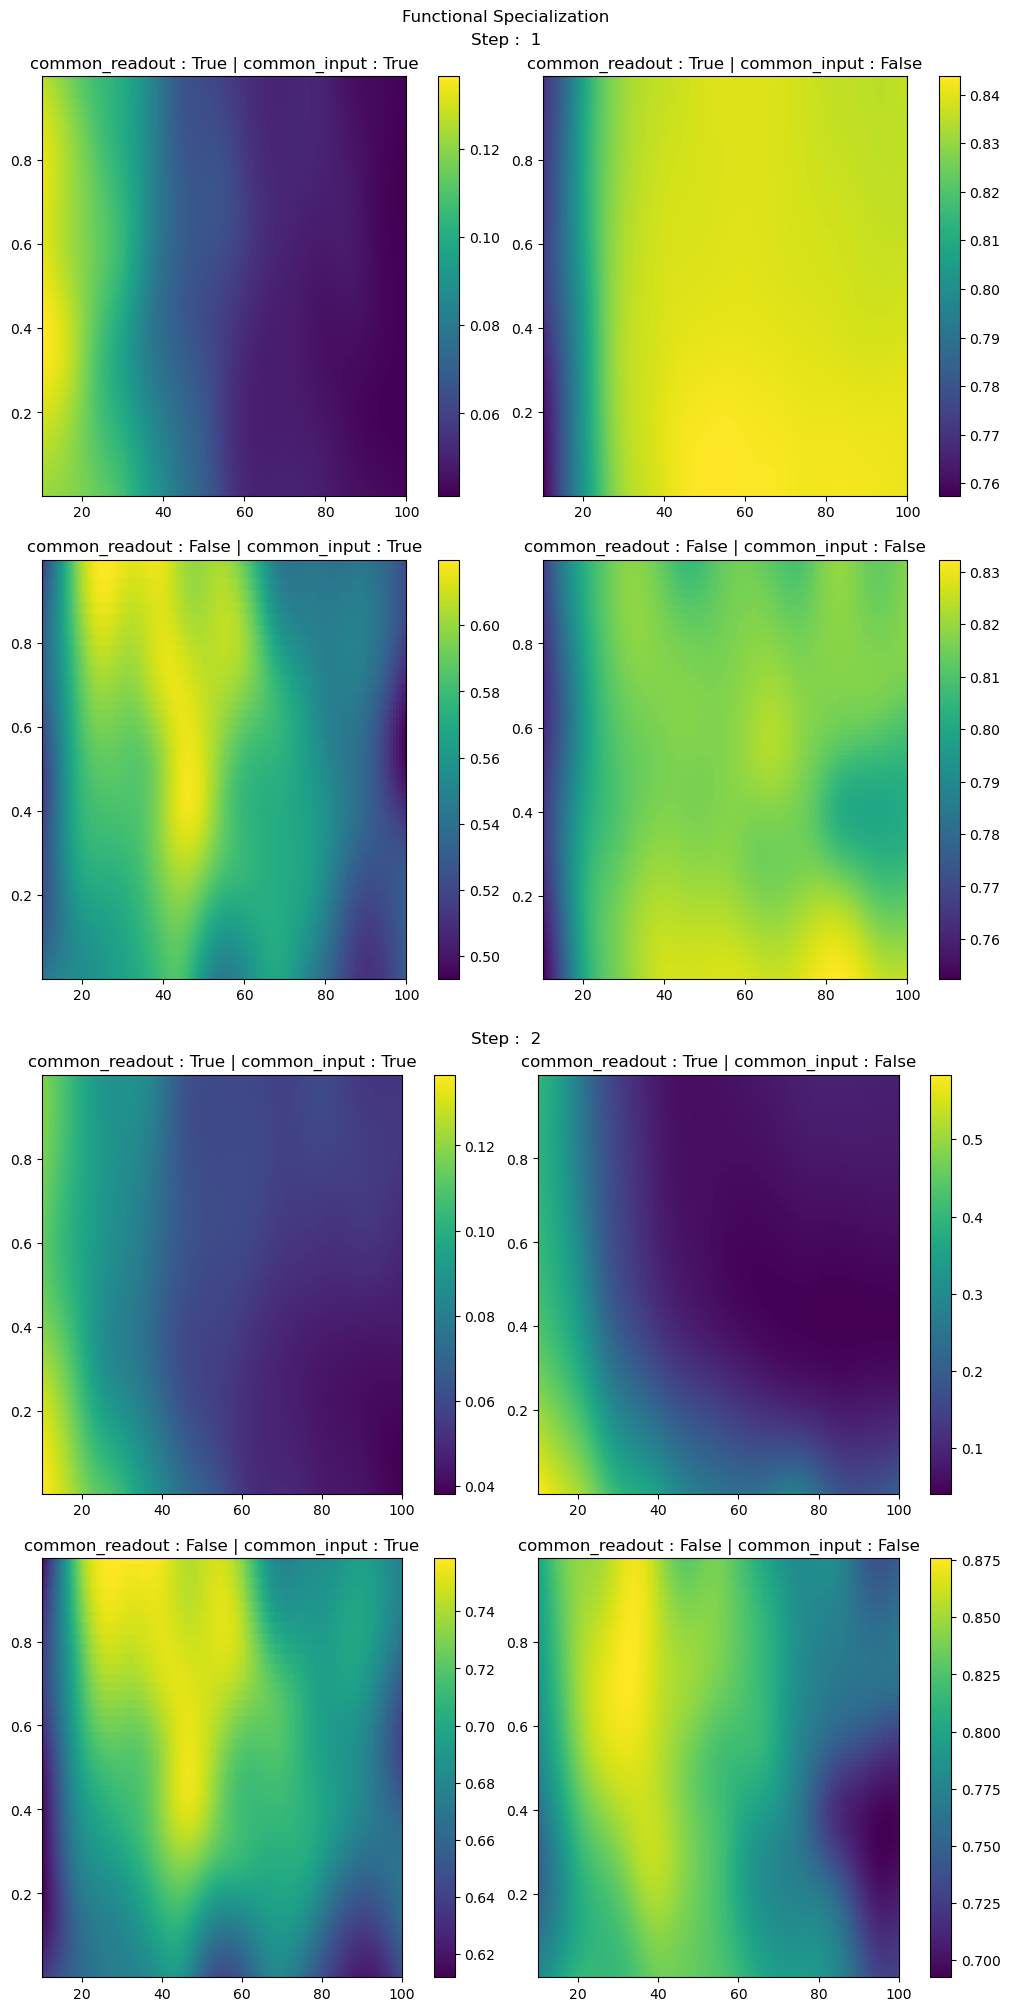

In [7]:
(n1, v_p1), (n2, v_p2) = (tuple(*v.items()) for v in varying_params)

n_tasks = len(f_data)

fig = plt.figure(
    constrained_layout=True, figsize=(5 * len(v_p1), 5 * n_tasks * len(v_p2))
)
fig.suptitle("Functional Specialization")

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=n_tasks, ncols=1)
if len(f_data) == 1:
    subfigs = [subfigs]

Zs = []

for t, (subfig, step) in enumerate(zip(subfigs, [1, 2])):

    #subfig.suptitle(f"Task :  {task}")
    subfig.suptitle(f"Step :  {step}")

    # create subplots per subfig

    axs = subfig.subplots(nrows=len(v_p1), ncols=len(v_p2))

    # t_values = task_values[task].copy()
    # norm_values = normalized_values[task]

    for i, v1 in enumerate(v_p1):
        for j, v2 in enumerate(v_p2):

            try:
                ax = axs[i, j]
            except IndexError:
                ax = axs[i + j]

            minmax = (
                f_data[t]["bottleneck_global_diff"].min(),
                f_data[t]["bottleneck_global_diff"].max(),
            )

            data = filter_data(filter_data(f_data[t], n1, v1), n2, v2)
            print(data.shape)
            values = get_values(data)

            if 0 not in data.shape : 

                (X, Y), (X_mesh, Y_mesh), Z_diff, sigmas = compute_and_plot(
                    values,
                    (fig, ax),
                    log_scale=True,
                    plot_f=False,
                    random=False,
                )

                Zs.append(Z_diff)

            ax.set_title(f"{n1} : {v1} | {n2} : {v2}")

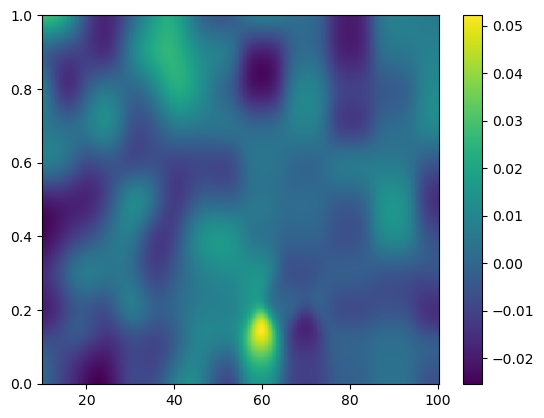

In [69]:
plt.pcolormesh(X_mesh, Y_mesh, Zs[1] - Zs[0], cmap="viridis")
plt.colorbar()

# Scipy

In [8]:
from scipy.interpolate import griddata as gd

In [26]:
def get_colormesh(values, method="nearest", log_scale=True):

    x_values, y_values, z_values = values

    resolution = 500
    eps = 1e-4

    if not log_scale:
        X = np.linspace(x_values.min(), x_values.max(), resolution)
        Y = np.linspace(
            y_values.min(), y_values.max(), resolution
        )  # 500 x 500 takes 10s
    else:
        X = np.geomspace(np.maximum(x_values.min(), eps), x_values.max(), resolution)
        Y = np.geomspace(np.maximum(y_values.min(), eps), y_values.max(), resolution)
        # print(Y)

    X_mesh, Y_mesh = np.meshgrid(X, Y)

    Z = gd(
        (x_values, y_values), z_values, (X_mesh, Y_mesh), method=method, rescale=True
    )

    return X_mesh, Y_mesh, Z


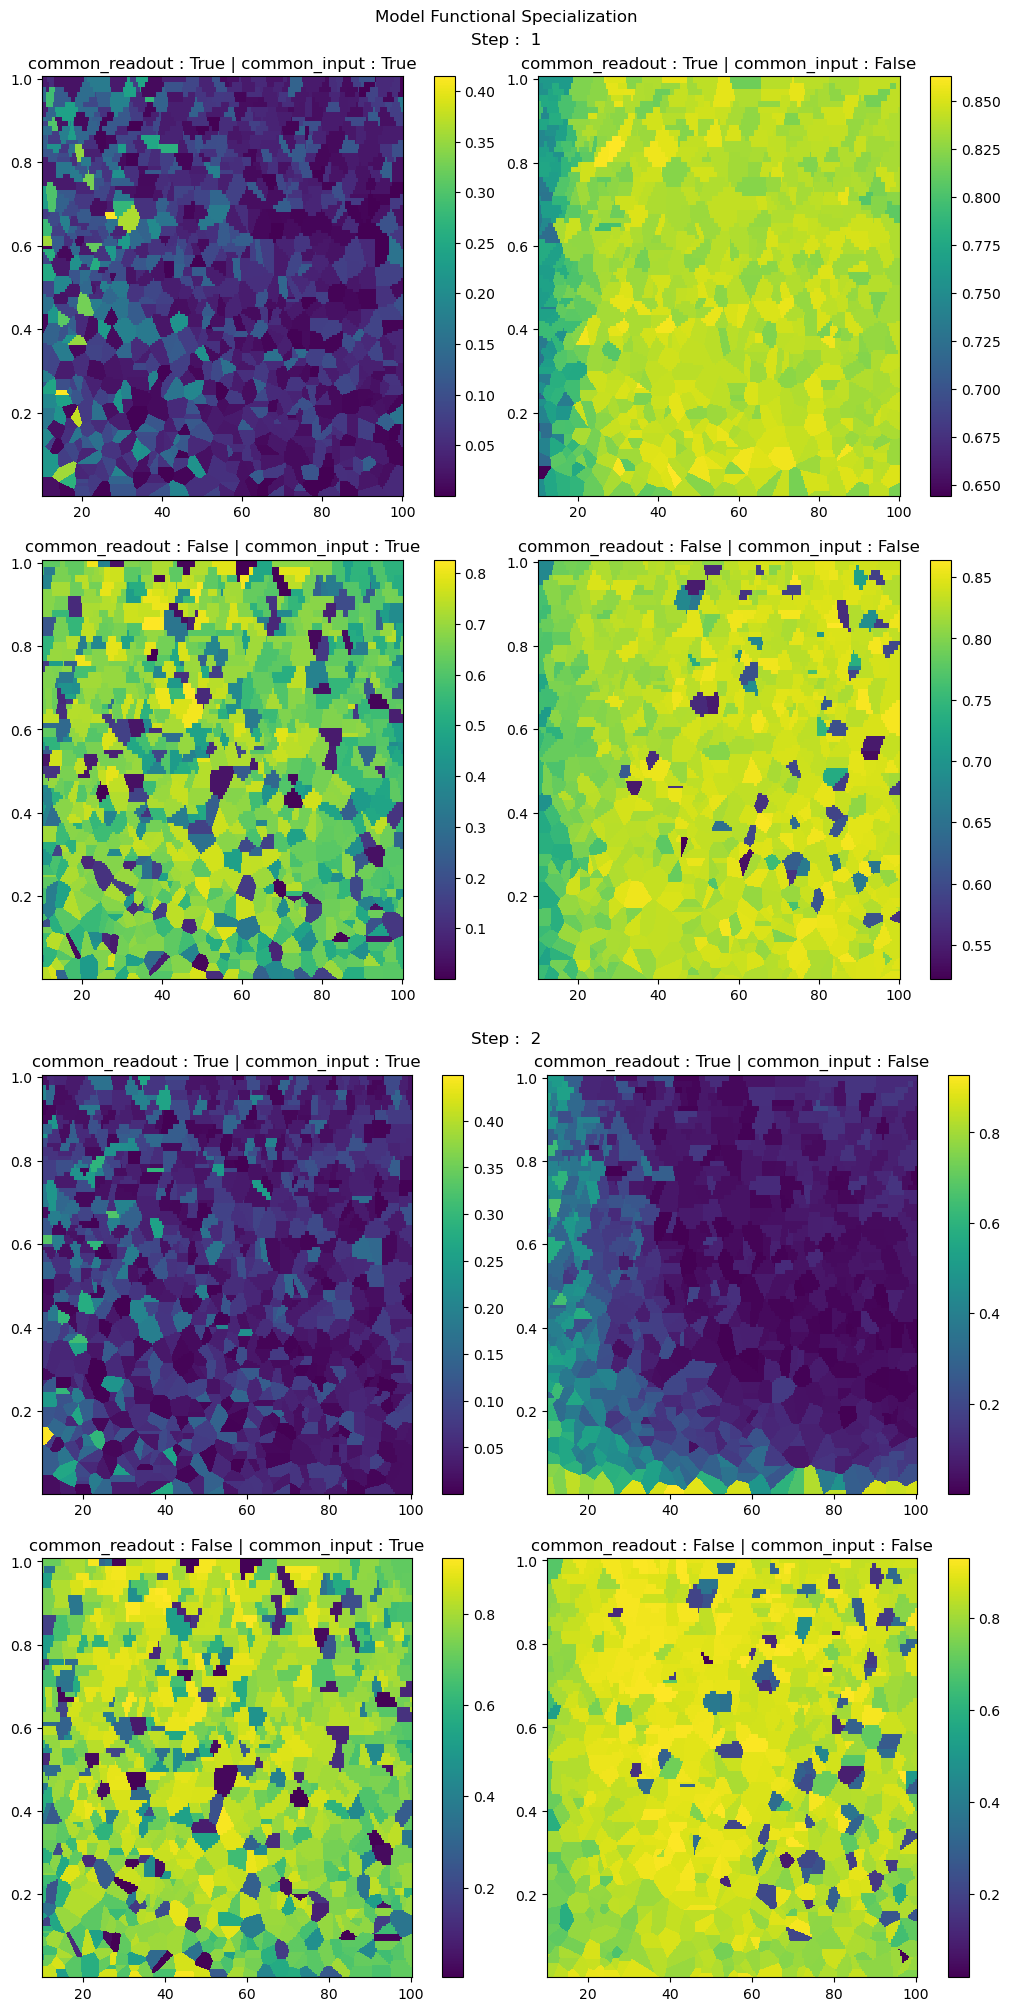

In [27]:
(n1, v_p1), (n2, v_p2) = (tuple(*v.items()) for v in varying_params)

fig = plt.figure(constrained_layout=True, figsize=(5 * len(v_p1), 5 * n_tasks * len(v_p2)))
fig.suptitle("Model Functional Specialization")

subfigs = fig.subfigures(nrows=2, ncols=1)

for t, (subfig, step) in enumerate(zip(subfigs, [1, 2])):

    #subfig.suptitle(f"Task :  {task}")
    subfig.suptitle(f"Step :  {step}")

    # create subplots per subfig
    
    axs = subfig.subplots(nrows=len(v_p1), ncols=len(v_p2))

    # t_values = task_values[task].copy()
    # norm_values = normalized_values[task]

    for i, v1 in enumerate(v_p1):
        for j, v2 in enumerate(v_p2):

            try:
                ax = axs[i, j]
            except IndexError:
                ax = axs[i + j]
            values = filter_data(filter_data(f_data[t], n1, v1), n2, v2)[
                ["n_hidden", "sparsity", "bottleneck_global_diff"]
            ].values.T

            X_mesh, Y_mesh, Z = get_colormesh(values)
            pcm = ax.pcolormesh(X_mesh, Y_mesh, Z, cmap="viridis")
            fig.colorbar(pcm, ax=ax)

            ax.set_title(f"{n1} : {v1} | {n2} : {v2}")

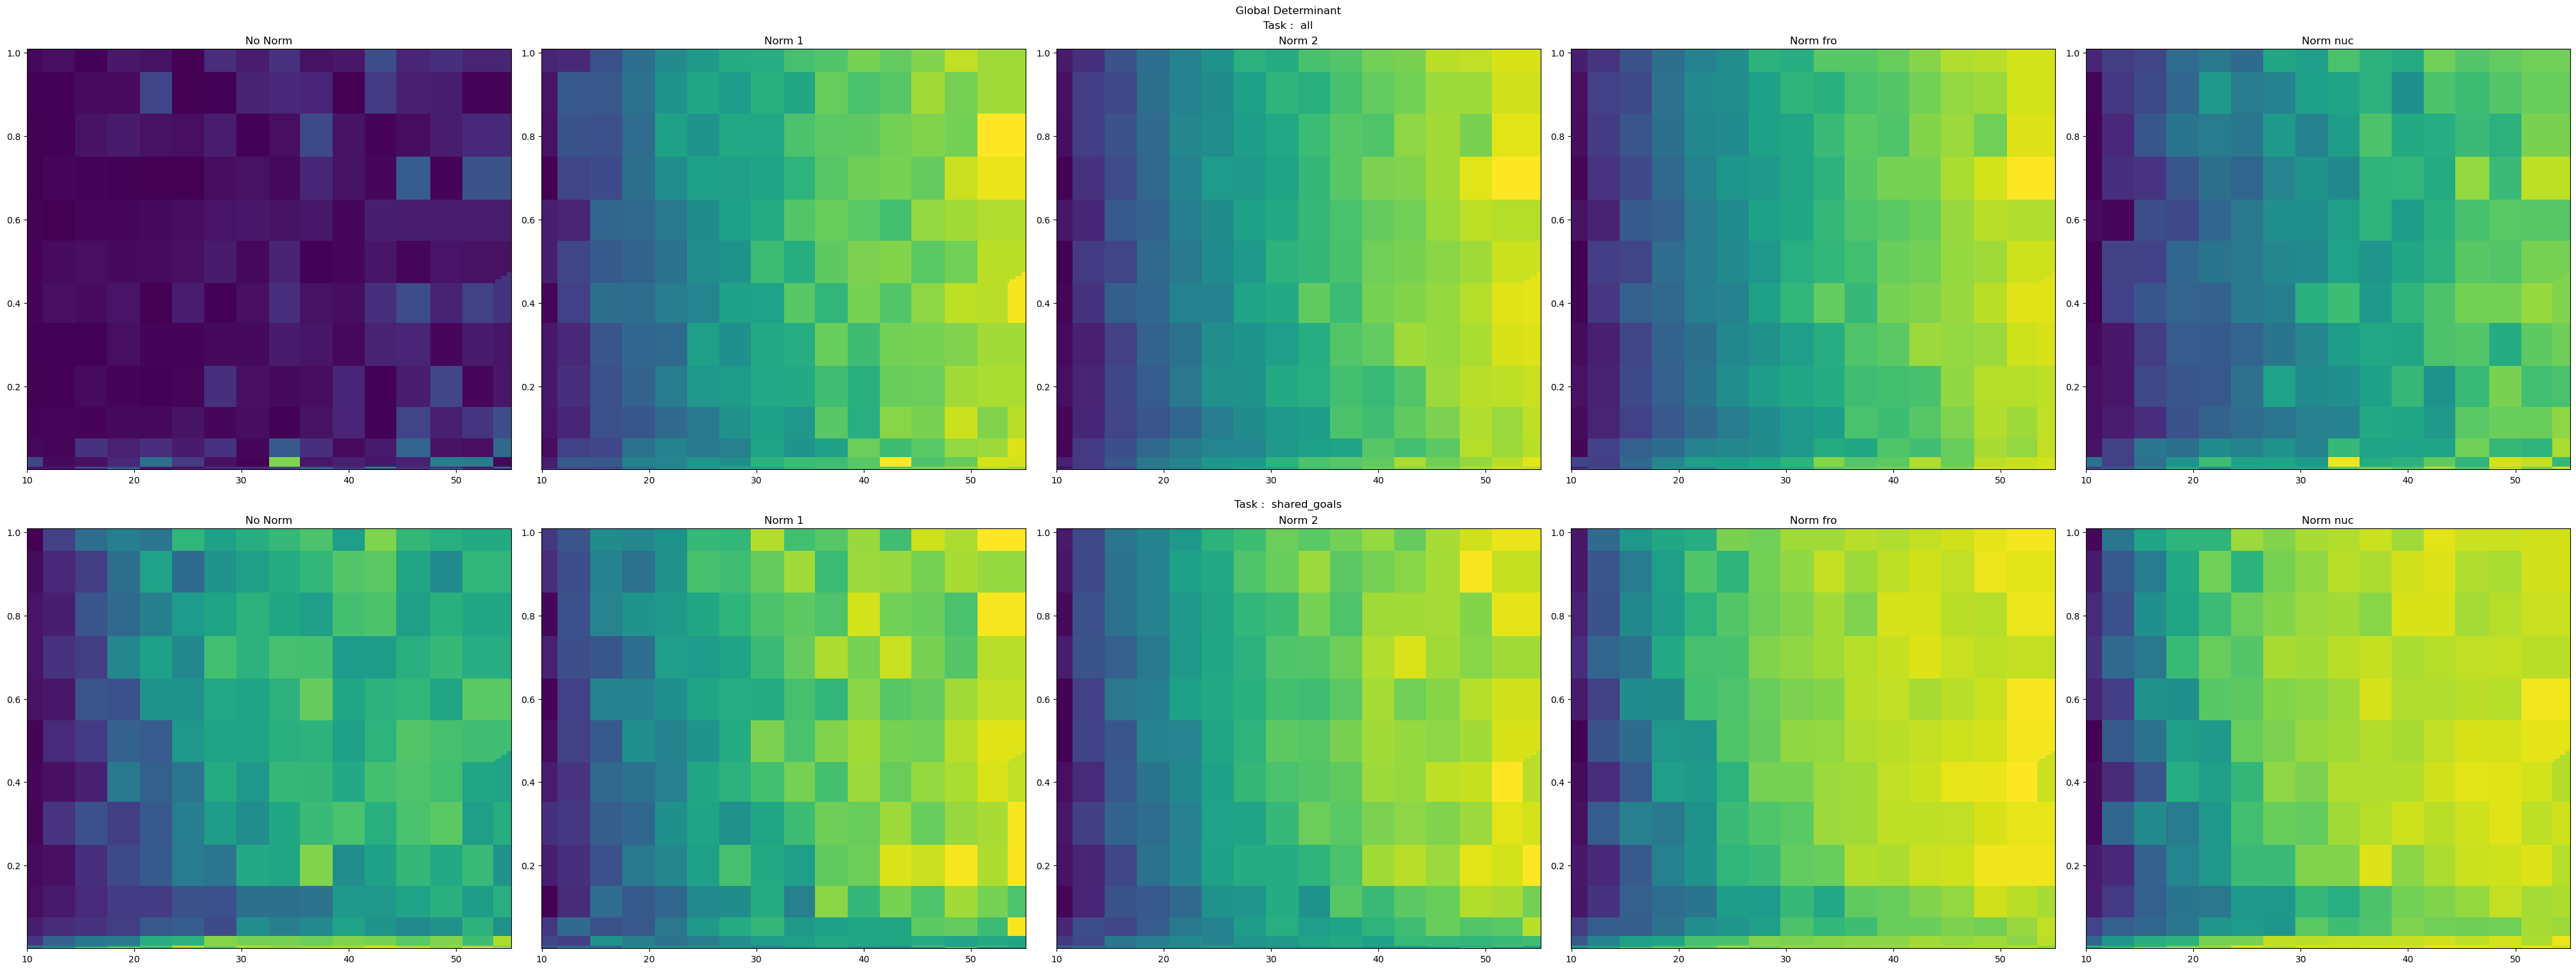

In [245]:
fig = plt.figure(constrained_layout=True, figsize=(40, 15))
fig.suptitle("Global Determinant")

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)

method = "linear"

for t, (subfig, task) in enumerate(zip(subfigs, tasks)):

    subfig.suptitle(f"Task :  {task}")
    # create subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=len(norms) + 1)

    t_values = task_values[task].copy()
    norm_values = normalized_values[task]
    ax = axs[0]

    X_mesh, Y_mesh, Z = get_colormesh(t_values)
    ax.pcolormesh(X_mesh, Y_mesh, Z, cmap="viridis")

    ax.set_title("No Norm")

    for (norm, n_values), ax in zip(norm_values.items(), axs[1:]):

        values = t_values.copy()
        values[-1] /= n_values

        X_mesh, Y_mesh, Z = get_colormesh(values)
        ax.pcolormesh(X_mesh, Y_mesh, Z, cmap="viridis")

        ax.set_title(f"Norm {norm}")

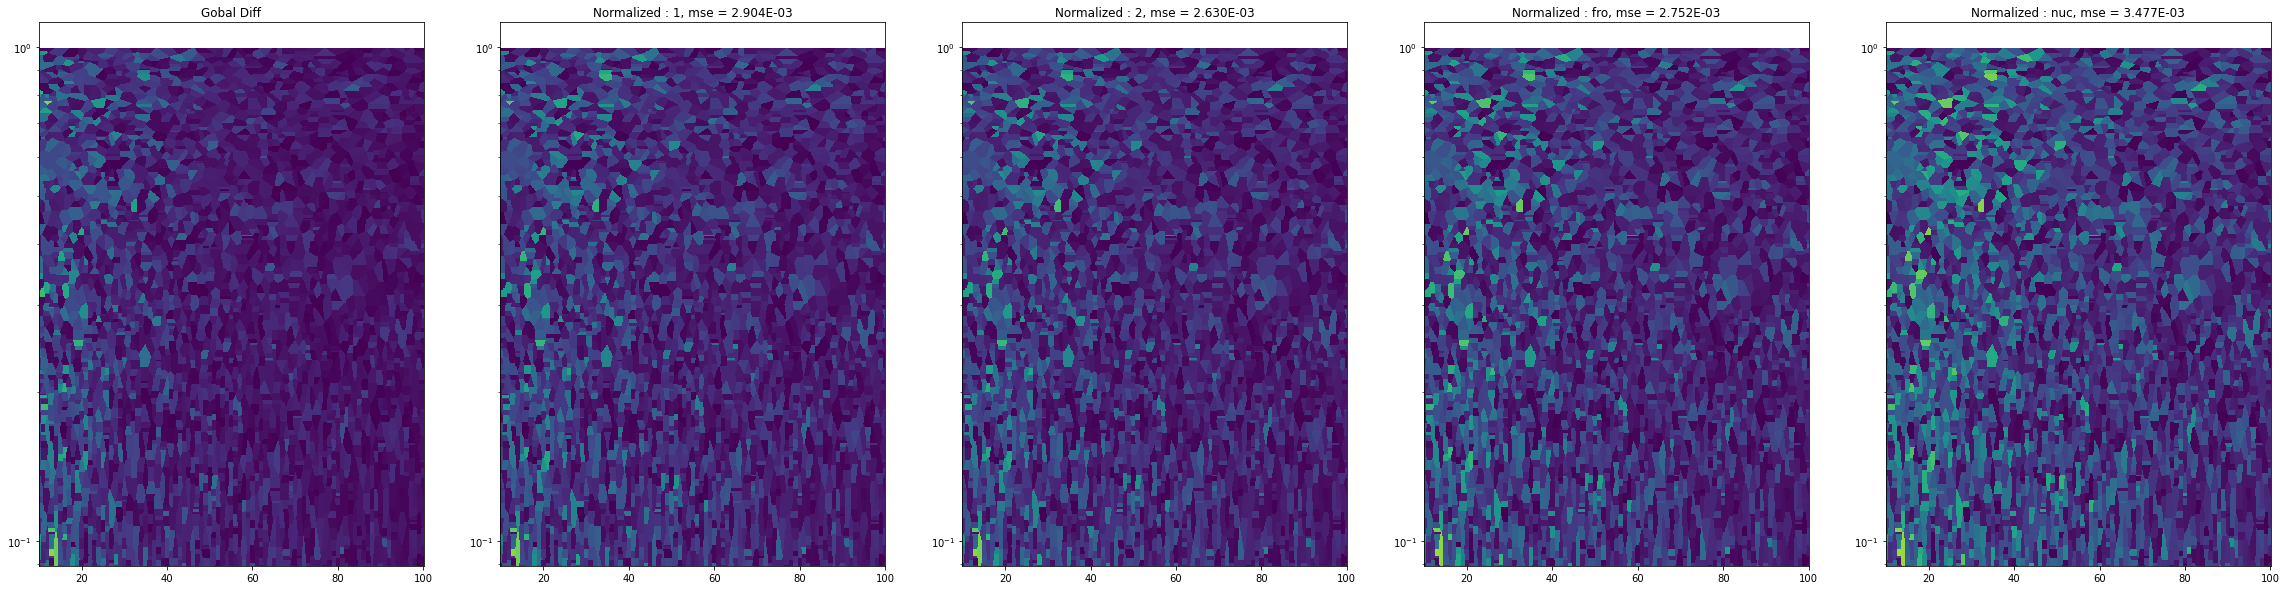

In [27]:
fig, axs = plt.subplots(1, len(norms) + 1, figsize=(40, 10))

Zs = []

ax = axs[0]

X_mesh, Y_mesh, Z = plot_colormesh(task_values[1])
ax.pcolormesh(X_mesh, Y_mesh, Z, cmap="viridis")

Zs.append(Z)

if log_scale:

    # plt.xscale("log")
    ax.set_yscale("log")

# plt.ylim(y_values.min(), y_values.max())
# plt.xlim(x_values.min(), x_values.max())

# plt.grid(True)
ax.set_title(f"Gobal Det")

for i, (ax, norm) in enumerate(zip(axs[1:], norms.items())):

    values = task_values[1]
    Z = gd(
        (x_values, y_values),
        z_values_det / norm[1],
        (X_mesh, Y_mesh),
        method="nearest",
        rescale=True,
    )
    ax.pcolormesh(X_mesh, Y_mesh, Z, cmap="viridis")

    # plt.imshow(Z)
    if log_scale:

        # plt.xscale("log")
        ax.set_yscale("log")

    # plt.ylim(y_values.min(), y_values.max())
    # plt.xlim(x_values.min(), x_values.max())

    # plt.grid(True)
    ax.set_title(f"Normalized : {norm[0]}, mse = {((Zs[0] - Z) ** 2).mean() :.3E}")
    Zs.append(Z)

fig.show()


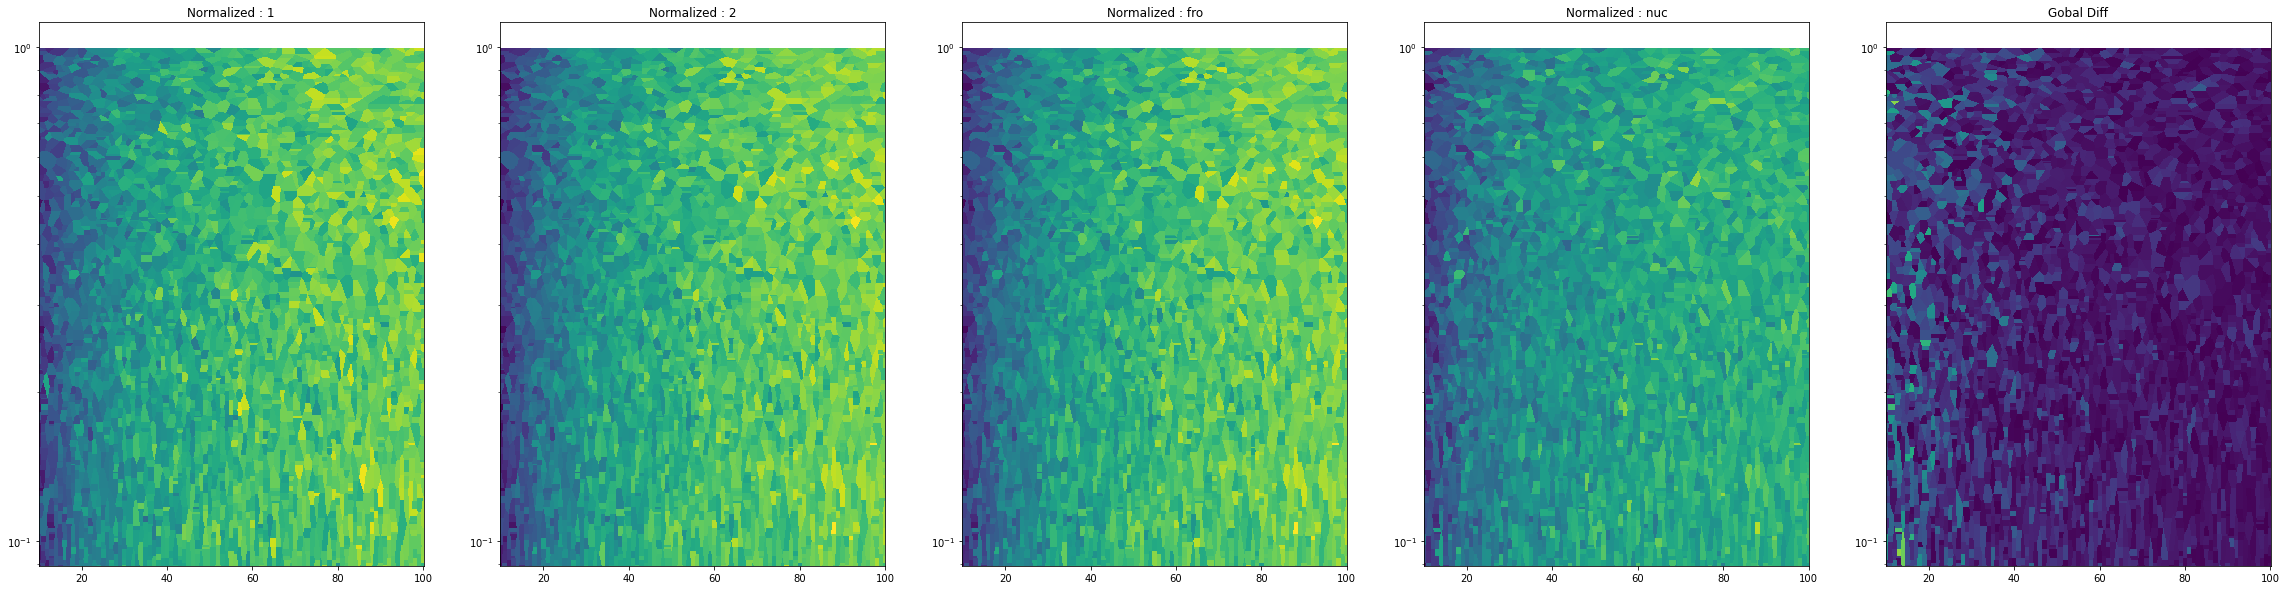

In [13]:
fig, axs = plt.subplots(1, len(norms) + 1, figsize=(40, 10))

Zs = []

for i, (ax, norm) in enumerate(zip(axs, norms.items())):

    Z = gd(
        (x_values, y_values), norm[1], (X_mesh, Y_mesh), method="nearest", rescale=True
    )
    ax.pcolormesh(X_mesh, Y_mesh, Z, cmap="viridis")

    # plt.imshow(Z)
    if log_scale:

        # plt.xscale("log")
        ax.set_yscale("log")

    # plt.ylim(y_values.min(), y_values.max())
    # plt.xlim(x_values.min(), x_values.max())

    # plt.grid(True)
    ax.set_title(f"Normalized : {norm[0]}")
    Zs.append(Z)

ax = axs[-1]

Z = gd(
    (x_values, y_values),
    z_values_diff,
    (X_mesh, Y_mesh),
    method="nearest",
    rescale=True,
)
ax.pcolormesh(X_mesh, Y_mesh, Z, cmap="viridis")

if log_scale:

    # plt.xscale("log")
    ax.set_yscale("log")

# plt.ylim(y_values.min(), y_values.max())
# plt.xlim(x_values.min(), x_values.max())

# plt.grid(True)
ax.set_title(f"Gobal Diff")
Zs.append(Z)

fig.show()


# Find new metric

In [2]:
import numpy as np
import numpy.linalg as LA
from numpy.linalg import LinAlgError


In [8]:
def agent_diff(col):
    return (col[1] - col[0]) / col.sum()


def global_diff(M):
    return np.abs(agent_diff(M[:, 0]) - agent_diff(M[:, 1])) / 2


def new_metric(M):
    return np.abs(LA.det(M)) / M.sum(0).prod()

In [29]:
n_agents = 2

M = np.random.rand(n_agents, n_agents)

M = np.eye(n_agents)
M[0, 1] = 1

new_metric(M), np.abs(LA.det(M))


(0.5, 1.0)

In [128]:
idxs = [0, 2]
sub_mat = lambda M, idx: np.delete(np.delete(M, idx[0], 0), idx[1], 1).squeeze()
sub_mat(M, idxs), M

(array([[0., 1.],
        [0., 0.]]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]))

In [180]:
def reccursive_new_metric(M):
    if M.shape[0] > 2:

        res = new_metric(M)

        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                subM = sub_mat(M, [i, j])
                res += reccursive_new_metric(subM)

    else:
        res = new_metric(M)

    print(res)
    return res